Importing the essential libraries and data

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer



import warnings
warnings.filterwarnings('ignore')

In [73]:
# reading the .data file using pandas

cols = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv('./auto-mpg.data', names=cols, na_values = "?",
                comment = '\t',
                sep= " ",
                skipinitialspace=True)

data = df.copy()

### EDA

Exploratory data analysis

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [75]:
data.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [76]:
data.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


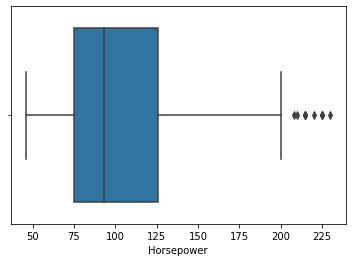

In [77]:
sns.boxplot(x=data['Horsepower'])

Null values in Horsepower column are to be taken care of with median imputation. Here we don't use mean due to slightly skewed nature of datapoints.

In [78]:
median = data['Horsepower'].median()
data['Horsepower'] = data['Horsepower'].fillna(median) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    398 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [79]:
data["Cylinders"].value_counts()/len(data)

4    0.512563
8    0.258794
6    0.211055
3    0.010050
5    0.007538
Name: Cylinders, dtype: float64

In [80]:
data["Origin"].value_counts()/len(data)

1    0.625628
3    0.198492
2    0.175879
Name: Origin, dtype: float64

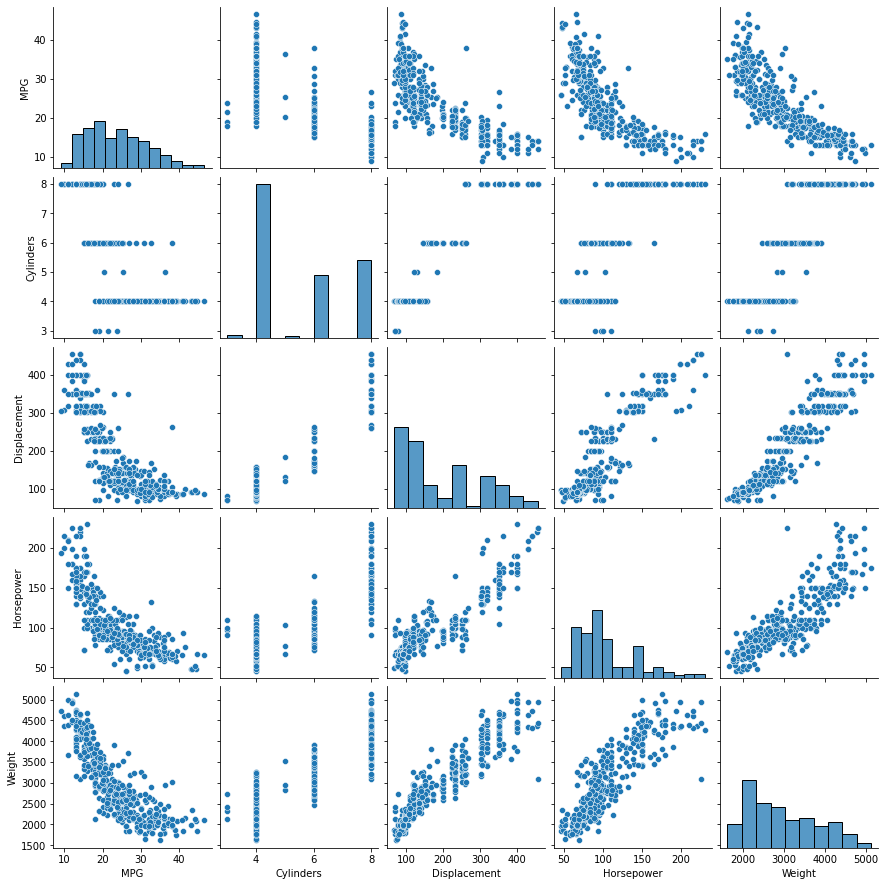

In [81]:
sns.pairplot(data[['MPG', 'Cylinders', 'Displacement', 'Horsepower','Weight']])

In [82]:
corrMatrix = data.corr()

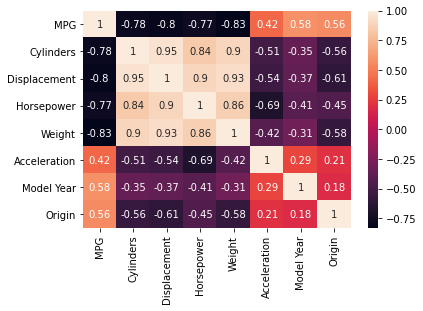

In [83]:
sns.heatmap(corrMatrix, annot=True)
plt.show()

Features Cylinders, Displacement, HP and Weight show very strong negative correlation with MPG value.

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    398 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


### Data Preparation

In [85]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["Cylinders"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [86]:
##segregate the feature and target variable
data = strat_train_set.drop("MPG", axis=1)
data_labels = strat_train_set["MPG"].copy()
data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
145,4,83.0,61.0,2003.0,19.0,74,3
151,4,79.0,67.0,2000.0,16.0,74,2
388,4,156.0,92.0,2585.0,14.5,82,1
48,6,250.0,88.0,3139.0,14.5,71,1
114,4,98.0,90.0,2265.0,15.5,73,2
...,...,...,...,...,...,...,...
147,4,90.0,75.0,2108.0,15.5,74,2
156,8,400.0,170.0,4668.0,11.5,75,1
395,4,135.0,84.0,2295.0,11.6,82,1
14,4,113.0,95.0,2372.0,15.0,70,3


A function is prepared that would convert the numbered country of origin to Object type form. This will later be OneHot Encoded.

In [87]:
##preprocess the Origin column in data
def preprocess_origin_cols(df):
    df["Origin"] = df["Origin"].map({1: "India", 2: "USA", 3: "Germany"})
    return df

Creation of two new features, Acceleration time/Cylinder and Acceleration time/HP. These would help epxlore the feature interrelation and their effect on prediction. 

In [88]:
##creating custom attribute adder class
acc_ix, hpower_ix, cyl_ix = 4,2, 0

class CustomAttrAdder(BaseEstimator, TransformerMixin):
    def __init__(self, acc_on_power=True): # no *args or **kargs
        self.acc_on_power = acc_on_power
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        acc_on_cyl = X[:, acc_ix] / X[:, cyl_ix]
        if self.acc_on_power:
            acc_on_power = X[:, acc_ix] / X[:, hpower_ix]
            return np.c_[X, acc_on_power, acc_on_cyl]
        
        return np.c_[X, acc_on_cyl]

### Pipeline for data processing

Now numerical and categorical features are prepared seperately and unified in a single pipeline. This would take dataset and convert it into ready to train form.

In [89]:
def num_pipeline_transformer(data):
    '''
    Function to process numerical transformations
    Argument:
        data: original dataframe 
    Returns:
        num_attrs: numerical dataframe
        num_pipeline: numerical pipeline object
        
    '''
    numerics = ['float64', 'int64']

    num_attrs = data.select_dtypes(include=numerics)

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attrs_adder', CustomAttrAdder()),
        ('std_scaler', StandardScaler()),
        ])
    return num_attrs, num_pipeline


def pipeline_transformer(data):
    '''
    Complete transformation pipeline for both
    nuerical and categorical data.
    
    Argument:
        data: original dataframe 
    Returns:
        prepared_data: transformed data, ready to use
    '''
    cat_attrs = ["Origin"]
    num_attrs, num_pipeline = num_pipeline_transformer(data)
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, list(num_attrs)),
        ("cat", OneHotEncoder(), cat_attrs),
        ])
    prepared_data = full_pipeline.fit_transform(data)
    return prepared_data

In [90]:
##from raw data to processed data in 2 steps
preprocessed_df = preprocess_origin_cols(data)
prepared_data = pipeline_transformer(preprocessed_df)
prepared_data

array([[-0.85657842, -1.07804475, -1.15261228, ...,  1.        ,
         0.        ,  0.        ],
       [-0.85657842, -1.1174582 , -0.99069325, ...,  0.        ,
         0.        ,  1.        ],
       [-0.85657842, -0.3587492 , -0.31603064, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.85657842, -0.56566984, -0.53192268, ...,  0.        ,
         1.        ,  0.        ],
       [-0.85657842, -0.78244384, -0.23507113, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.32260746, -0.45728283,  0.43959149, ...,  1.        ,
         0.        ,  0.        ]])

### Model Selection


Linear regression

In [91]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(prepared_data, data_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [92]:
from sklearn.metrics import mean_squared_error

mpg_predictions = lin_reg.predict(prepared_data)
lin_mse = mean_squared_error(data_labels, mpg_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.9599557382767734

Decision tree

In [93]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(prepared_data, data_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [94]:
mpg_predictions = tree_reg.predict(prepared_data)
tree_mse = mean_squared_error(data_labels, mpg_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

*Overfitting Expected here*

Try K fold cross validation for evaluation

In [95]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, 
                         prepared_data, 
                         data_labels, 
                         scoring="neg_mean_squared_error", 
                         cv = 10)
tree_reg_rmse_scores = np.sqrt(-scores)

In [96]:
tree_reg_rmse_scores

array([2.91451111, 3.02979991, 2.92489316, 3.34897372, 2.25173544,
       3.01667242, 3.27337746, 3.72126491, 4.19984639, 2.51441008])

In [97]:
tree_reg_rmse_scores.mean()

3.1195484603259453

In [98]:
scores = cross_val_score(lin_reg, prepared_data, data_labels, scoring="neg_mean_squared_error", cv = 10)
lin_reg_rmse_scores = np.sqrt(-scores)
lin_reg_rmse_scores

array([3.43029715, 3.45041922, 3.66364877, 2.59538773, 2.48739898,
       2.746598  , 3.32560073, 2.42211361, 3.78139392, 2.86493978])

In [99]:
lin_reg_rmse_scores.mean()

3.076779788960899

Random forest

In [100]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(prepared_data, data_labels)
forest_reg_cv_scores = cross_val_score(forest_reg,
                                         prepared_data,
                                         data_labels,
                                         scoring='neg_mean_squared_error',
                                         cv = 10)

forest_reg_rmse_scores = np.sqrt(-forest_reg_cv_scores)
forest_reg_rmse_scores.mean()

2.5342479615172375

SVM Regressor

In [101]:
from sklearn.svm import SVR

svm_reg = SVR(kernel='linear')
svm_reg.fit(prepared_data, data_labels)
svm_cv_scores = cross_val_score(svm_reg, prepared_data, data_labels,
                                scoring='neg_mean_squared_error',
                                cv = 10)
svm_rmse_scores = np.sqrt(-svm_cv_scores)
svm_rmse_scores.mean()

3.088411910825019

### Hyperparameter Tuning

In [109]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           cv=10,
                          )

grid_search.fit(prepared_data, data_labels)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [110]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [111]:
cv_scores = grid_search.cv_results_

##printing all the parameters along with their scores
for mean_score, params in zip(cv_scores['mean_test_score'], cv_scores["params"]):
    print(np.sqrt(-mean_score), params)

3.2908152056507123 {'max_features': 2, 'n_estimators': 3}
3.108650597655911 {'max_features': 2, 'n_estimators': 10}
2.914785975838747 {'max_features': 2, 'n_estimators': 30}
3.479375661741588 {'max_features': 4, 'n_estimators': 3}
2.861608446874905 {'max_features': 4, 'n_estimators': 10}
2.754034923971589 {'max_features': 4, 'n_estimators': 30}
3.0707725479459786 {'max_features': 6, 'n_estimators': 3}
2.7635034212524854 {'max_features': 6, 'n_estimators': 10}
2.62605124196921 {'max_features': 6, 'n_estimators': 30}
3.022486403466488 {'max_features': 8, 'n_estimators': 3}
2.757075829029033 {'max_features': 8, 'n_estimators': 10}
2.6705644346545125 {'max_features': 8, 'n_estimators': 30}
3.43176674053898 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
2.832833696409321 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
3.234387939778108 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
2.7971961930366467 {'bootstrap': False, 'max_features': 3, 'n_estimators':

### feature importance

In [112]:
# feature importances 

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.18042004, 0.31535979, 0.1325219 , 0.16579162, 0.01820109,
       0.11382022, 0.02695148, 0.03768779, 0.00240961, 0.00526124,
       0.00157521])

In [113]:
extra_attrs = ["acc_on_power", "acc_on_cyl"]
numerics = ['float64', 'int64']
num_attrs = list(data.select_dtypes(include=numerics))

attrs = num_attrs + extra_attrs
sorted(zip(attrs, feature_importances), reverse=True)

[('acc_on_power', 0.026951478589707707),
 ('acc_on_cyl', 0.0376877926465764),
 ('Weight', 0.16579162097919833),
 ('Model Year', 0.11382022369842613),
 ('Horsepower', 0.13252190422079682),
 ('Displacement', 0.3153597899672077),
 ('Cylinders', 0.18042004400719217),
 ('Acceleration', 0.018201090590496745)]

### Evaluation on test data

In [114]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("MPG", axis=1)
y_test = strat_test_set["MPG"].copy()

X_test_preprocessed = preprocess_origin_cols(X_test)
X_test_prepared = pipeline_transformer(X_test_preprocessed)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [115]:
final_rmse

2.9892382204984758

### Function to cover the entire flow of results

In [116]:
def predict_mpg(config, model):
    
    if type(config) == dict:
        df = pd.DataFrame(config)
    else:
        df = config
    
    preproc_df = preprocess_origin_cols(df)
    prepared_df = pipeline_transformer(preproc_df)
    y_pred = model.predict(prepared_df)
    return y_pred

In [117]:
##checking it on a random sample
vehicle_config = {
    'Cylinders': [4, 6, 8],
    'Displacement': [155.0, 160.0, 165.5],
    'Horsepower': [93.0, 130.0, 98.0],
    'Weight': [2500.0, 3150.0, 2600.0],
    'Acceleration': [15.0, 14.0, 16.0],
    'Model Year': [81, 80, 78],
    'Origin': [3, 2, 1]
}

predict_mpg(vehicle_config, final_model)

array([32.55333333, 18.17333333, 19.74      ])

### Save the model

In [118]:
import pickle
##saving the model
with open("model.bin", 'wb') as f_out:
    pickle.dump(final_model, f_out)
    f_out.close()
##loading the model from the saved file
with open('model.bin', 'rb') as f_in:
    model = pickle.load(f_in)

predict_mpg(vehicle_config, model)

array([32.55333333, 18.17333333, 19.74      ])